In [6]:
%matplotlib inline

In [7]:
from typing import Optional, Dict, Callable, Tuple

import numpy as np
import itertools

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

In [8]:
def plot_contours(
    log_prob_func: Callable,
    ax: Optional[plt.Axes] = None,
    bounds: Tuple[float, float] = (-5.0, 5.0),
    grid_width_n_points: int = 20,
    n_contour_levels: Optional[int] = None,
    log_prob_min: float = -1000.0,
):
    """Plot contours of a log_prob_func that is defined on 2D"""
    if ax is None:
        fig, ax = plt.subplots(1)
    x_points_dim1 = torch.linspace(bounds[0], bounds[1], grid_width_n_points)
    x_points_dim2 = x_points_dim1
    x_points = torch.tensor(list(itertools.product(x_points_dim1, x_points_dim2)))
    log_p_x = log_prob_func(x_points).detach()
    log_p_x = torch.clamp_min(log_p_x, log_prob_min)
    log_p_x = log_p_x.reshape((grid_width_n_points, grid_width_n_points))
    x_points_dim1 = (
        x_points[:, 0].reshape((grid_width_n_points, grid_width_n_points)).numpy()
    )
    x_points_dim2 = (
        x_points[:, 1].reshape((grid_width_n_points, grid_width_n_points)).numpy()
    )
    if n_contour_levels:
        ax.contour(x_points_dim1, x_points_dim2, log_p_x, levels=n_contour_levels)
    else:
        ax.contour(x_points_dim1, x_points_dim2, log_p_x)


def plot_marginal_pair(
    samples: torch.Tensor,
    ax: Optional[plt.Axes] = None,
    marginal_dims: Tuple[int, int] = (0, 1),
    bounds: Tuple[float, float] = (-5.0, 5.0),
    alpha: float = 0.5,
):
    """Plot samples from marginal of distribution for a given pair of dimensions."""
    if not ax:
        fig, ax = plt.subplots(1)
    samples = torch.clamp(samples, bounds[0], bounds[1])
    samples = samples.cpu().detach()
    ax.plot(
        samples[:, marginal_dims[0]], samples[:, marginal_dims[1]], "o", alpha=alpha
    )

# DoubleMultiWell from FAB / DEM

In [9]:
def rejection_sampling(
    n_samples: int,
    proposal: torch.distributions.Distribution,
    target_log_prob_fn: Callable,
    k: float,
) -> torch.Tensor:
    """Rejection sampling. See Pattern Recognition and ML by Bishop Chapter 11.1"""
    z_0 = proposal.sample((n_samples * 10,))
    u_0 = (
        torch.distributions.Uniform(0, k * torch.exp(proposal.log_prob(z_0)))
        .sample()
        .to(z_0)
    )
    accept = torch.exp(target_log_prob_fn(z_0)) > u_0
    samples = z_0[accept]
    if samples.shape[0] >= n_samples:
        return samples[:n_samples]
    else:
        required_samples = n_samples - samples.shape[0]
        new_samples = rejection_sampling(
            required_samples, proposal, target_log_prob_fn, k
        )
        samples = torch.concat([samples, new_samples], dim=0)
        return samples


class DoubleWellEnergy(nn.Module):
    def __init__(self, dim=2, a=-0.5, b=-6.0, c=1.0):
        assert dim == 2  # We only use the 2D version
        super().__init__()
        self._dim = dim
        self._a = a
        self._b = b
        self._c = c
        if self._a == -0.5 and self._b == -6 and self._c == 1.0:
            # Define proposal params
            self.component_mix = torch.tensor([0.2, 0.8])
            self.means = torch.tensor([-1.7, 1.7])
            self.scales = torch.tensor([0.5, 0.5])
            
    def move_to_device(self, device):
        self.component_mix = self.component_mix.to(device)
        self.means = self.means.to(device)
        self.scales = self.scales.to(device)

    def _energy_dim_1(self, x_1):
        return self._a * x_1 + self._b * x_1.pow(2) + self._c * x_1.pow(4)

    def _energy_dim_2(self, x_2):
        return 0.5 * x_2.pow(2)

    def _energy(self, x):
        x_1 = x[:, 0]
        x_2 = x[:, 1]
        e1 = self._energy_dim_1(x_1)
        e2 = self._energy_dim_2(x_2)
        return e1 + e2
    
    def energy(self, x, temperature=None):
        assert x.shape[-1] == self._dim, "`x` does not match `dim`"
        if temperature is None:
            temperature = 1.0
        return self._energy(x) / temperature

    def force(self, x, temperature=None):
        x = x.requires_grad_(True)
        e = self.energy(x, temperature=temperature)
        return -torch.autograd.grad(e.sum(), x)[0]

    def log_prob(self, x):
        return torch.squeeze(-self.energy(x))

    def sample_first_dimension(self, shape):
        assert len(shape) == 1
        # see fab.sampling_methods.rejection_sampling_test.py
        if self._a == -0.5 and self._b == -6 and self._c == 1.0:
            # Define target.
            def target_log_prob(x):
                return -(x**4) + 6 * x**2 + 1 / 2 * x

            TARGET_Z = 11784.50927

            # Define proposal
            mix = torch.distributions.Categorical(self.component_mix)
            com = torch.distributions.Normal(self.means, self.scales)

            proposal = torch.distributions.MixtureSameFamily(
                mixture_distribution=mix, component_distribution=com
            )

            k = TARGET_Z * 3

            samples = rejection_sampling(shape[0], proposal, target_log_prob, k)
            return samples
        else:
            raise NotImplementedError

    def sample(self, shape):
        if self._a == -0.5 and self._b == -6 and self._c == 1.0:
            dim1_samples = self.sample_first_dimension(shape)
            dim2_samples = torch.distributions.Normal(
                torch.tensor(0.0).to(dim1_samples.device),
                torch.tensor(1.0).to(dim1_samples.device),
            ).sample(shape)
            return torch.stack([dim1_samples, dim2_samples], dim=-1)
        else:
            raise NotImplementedError

    @property
    def log_Z_2D(self):
        if self._a == -0.5 and self._b == -6 and self._c == 1.0:
            log_Z_dim0 = np.log(11784.50927)
            log_Z_dim1 = 0.5 * np.log(2 * torch.pi)
            return log_Z_dim0 + log_Z_dim1
        else:
            raise NotImplementedError

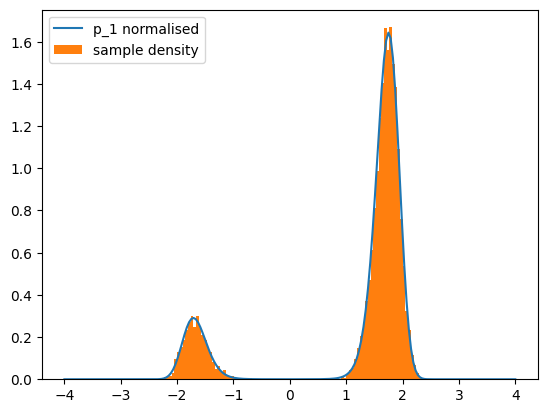

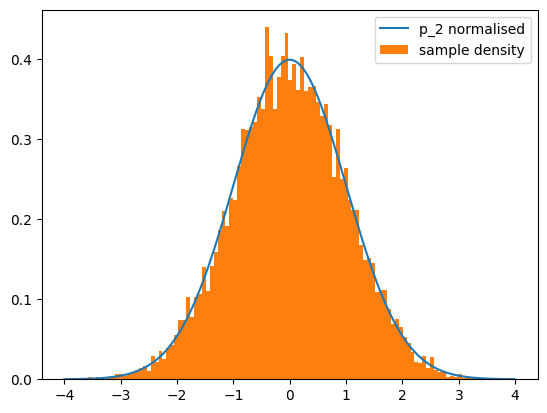

In [10]:
# Test that rejection sampling is work as desired.
target = DoubleWellEnergy(2)

x_linspace = torch.linspace(-4, 4, 200)

Z_dim_1 = 11784.50927
samples = target.sample((10000,))
p_1 = torch.exp(-target._energy_dim_1(x_linspace))
# plot first dimension vs normalised log prob
plt.close()
plt.plot(x_linspace, p_1 / Z_dim_1, label="p_1 normalised")
plt.hist(samples[:, 0], density=True, bins=100, label="sample density")
plt.legend()
plt.show()

# Now dimension 2.
Z_dim_2 = (2 * torch.pi) ** 0.5
p_2 = torch.exp(-target._energy_dim_2(x_linspace))
# plot first dimension vs normalised log prob
plt.plot(x_linspace, p_2 / Z_dim_2, label="p_2 normalised")
plt.hist(samples[:, 1], density=True, bins=100, label="sample density")
plt.legend()
plt.show()

In [11]:
class ManyWellEnergy(DoubleWellEnergy):
    """Many Well target distribution create by repeating the Double Well Boltzmann distribution."""

    def __init__(
        self,
        dim=4,
        use_gpu: bool = True,
        normalised: bool = False,
        a=-0.5,
        b=-6.0,
        c=1.0,
    ):
        assert dim % 2 == 0
        self.n_wells = dim // 2
        super(ManyWellEnergy, self).__init__(dim=2, a=a, b=b, c=c)
        self.dim = dim
        self.centre = 1.7
        self.max_dim_for_all_modes = (
            40  # otherwise we get memory issues on huuuuge test set
        )
        if self.dim < self.max_dim_for_all_modes:
            dim_1_vals_grid = torch.meshgrid(
                [torch.tensor([-self.centre, self.centre]) for _ in range(self.n_wells)],
                indexing="ij"
            )
            dim_1_vals = torch.stack(
                [torch.flatten(dim) for dim in dim_1_vals_grid], dim=-1
            )
            n_modes = 2**self.n_wells
            assert n_modes == dim_1_vals.shape[0]
            test_set = torch.zeros((n_modes, dim))
            test_set[:, torch.arange(dim) % 2 == 0] = dim_1_vals
            self.register_buffer("_test_set_modes", test_set)
        else:
            print("using test set containing not all modes to prevent memory issues")

        self.shallow_well_bounds = [-1.75, -1.65]
        self.deep_well_bounds = [1.7, 1.8]

        if use_gpu:
            if torch.cuda.is_available():
                self.cuda()
                self.device = "cuda"
            else:
                self.device = "cpu"
        else:
            self.device = "cpu"
        self.normalised = normalised

    @property
    def log_Z(self):
        return torch.tensor(self.log_Z_2D * self.n_wells)

    @property
    def Z(self):
        return torch.exp(self.log_Z)

    def sample(self, shape):
        """Sample by sampling each pair of dimensions from the double well problem
        using rejection sampling for the first dimension, and exact sampling for the second.
        """
        return torch.concat(
            [super(ManyWellEnergy, self).sample(shape) for _ in range(self.n_wells)],
            dim=-1,
        )

    # def get_modes_test_set_iterator(self, batch_size: int):
    #     """Test set created from points manually placed near each mode."""
    #     if self.dim < self.max_dim_for_all_modes:
    #         test_set = self._test_set_modes
    #     else:
    #         outer_batch_size = int(1e4)
    #         test_set = torch.zeros((outer_batch_size, self.dim))
    #         test_set[:, torch.arange(self.dim) % 2 == 0] = \
    #             -self.centre + self.centre * 2 * \
    #             torch.randint(high=2, size=(outer_batch_size, int(self.dim/2)))
    # # https://github.com/lollcat/fab-torch/blob/master/fab/utils/training.py
    #     return DatasetIterator(batch_size=batch_size, dataset=test_set,
    #                            device=self.device)

    def log_prob(self, x):
        log_prob = torch.sum(
            torch.stack(
                [
                    super(ManyWellEnergy, self).log_prob(x[:, i * 2 : i * 2 + 2])
                    for i in range(self.n_wells)
                ]
            ),
            dim=0,
        )
        if self.normalised:
            return log_prob - self.log_Z
        else:
            return log_prob

    def log_prob_2D(self, x):
        # for plotting, given 2D x
        return super(ManyWellEnergy, self).log_prob(x)

    def performance_metrics(
        self,
        samples: torch.Tensor,
        log_w: torch.Tensor,
        log_q_fn: Optional[Callable] = None,
        batch_size: Optional[int] = None,
    ) -> Dict:

        del samples
        n_runs = 50
        n_vals_per_split = log_w.shape[0] // n_runs
        log_w = log_w[: n_vals_per_split * n_runs]
        log_w = torch.stack(log_w.split(n_runs), dim=-1)

        # Check accuracy in estimating normalisation constant.
        log_Z_estimate = torch.logsumexp(log_w, dim=-1) - np.log(log_w.shape[-1])
        relative_error = torch.exp(log_Z_estimate - self.log_Z) - 1
        MSE_Z_estimate = torch.mean(torch.abs(relative_error))

        abs_MSE_log_Z_estimate = torch.mean(torch.abs(log_Z_estimate - self.log_Z))

        info = {}
        info.update(relative_MSE_Z_estimate=MSE_Z_estimate.cpu().item())
        info.update(abs_MSE_log_Z_estimate=abs_MSE_log_Z_estimate.cpu().item())

        if log_q_fn is not None:
            # Used later for estimation of test set probabilities.
            assert batch_size is not None
            n_batches = max(log_w.shape[0] // batch_size, 1)

            sum_log_prob = 0.0
            sum_log_prob_exact = 0.0
            sum_kl_exact = 0.0
            test_set_iterator_modes = self.get_modes_test_set_iterator(
                batch_size=batch_size
            )

            for x in test_set_iterator_modes:
                # Mode test set.
                log_q_x_modes = torch.sum(log_q_fn(x)).detach().cpu()
                sum_log_prob += log_q_x_modes

            for _ in range(n_batches):
                # Samples from p test set.
                x_exact = self.sample((batch_size,))
                log_q_x_exact = log_q_fn(x_exact)
                sum_log_prob_exact += torch.sum(log_q_x_exact).detach().cpu()
                sum_kl_exact += (
                    torch.sum(self.log_prob(x_exact) - self.log_Z - log_q_x_exact)
                    .detach()
                    .cpu()
                )

            eval_batch_size = batch_size * n_batches

            info.update(
                test_set_modes_mean_log_prob=(
                    sum_log_prob / test_set_iterator_modes.test_set_n_points
                )
                .cpu()
                .item(),
                test_set_exact_mean_log_prob=(sum_log_prob_exact / eval_batch_size)
                .cpu()
                .item(),
                forward_kl=(sum_kl_exact / eval_batch_size).cpu().item(),
                eval_batch_size=eval_batch_size,
            )
        return info

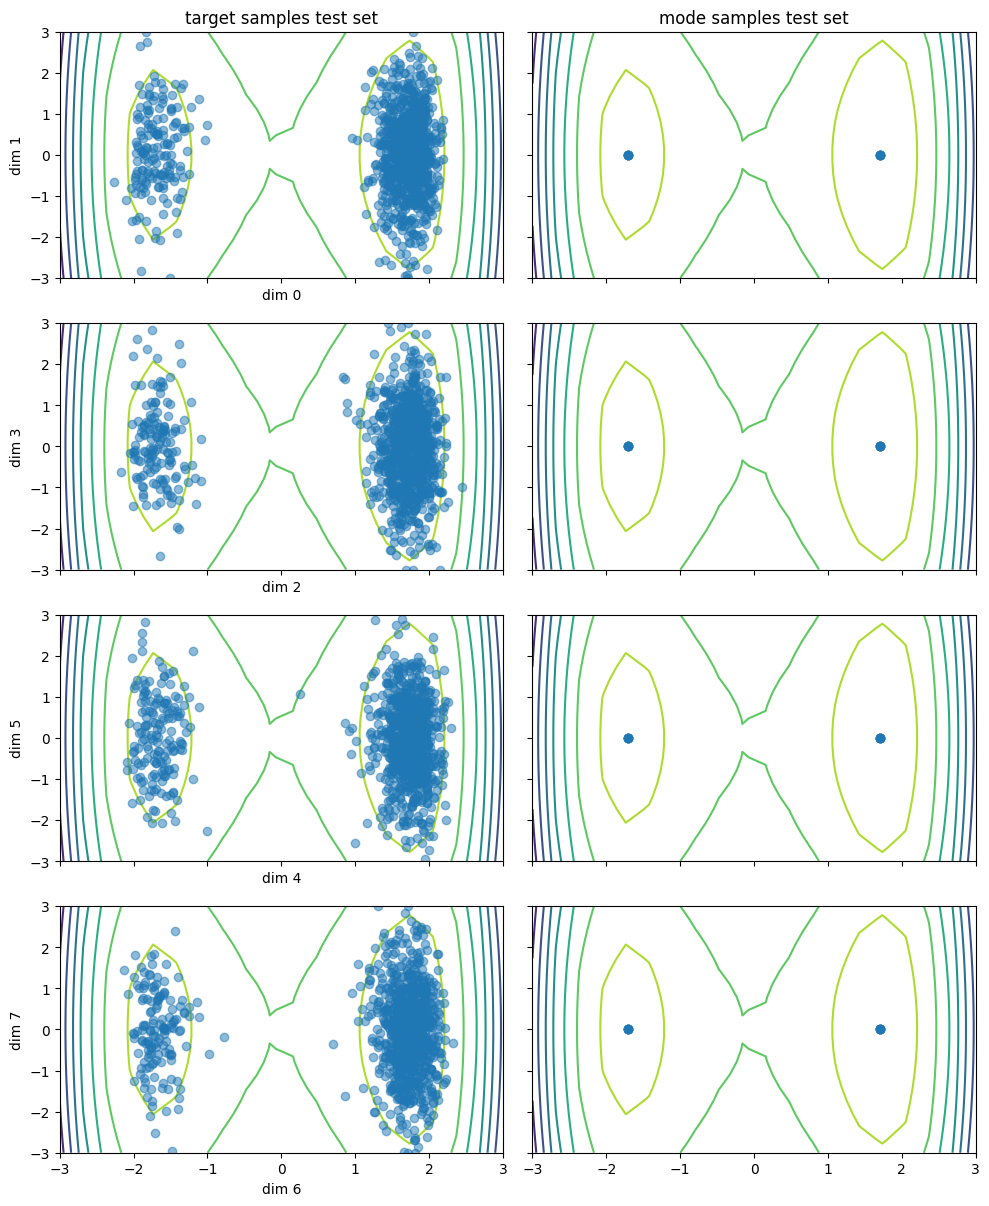

In [12]:
dim = 8
target = ManyWellEnergy(dim=dim)
samples = target.sample((1000,))
samples_modes = target._test_set_modes


plotting_bounds = (-3, 3)
n_rows = dim // 2
fig, axs = plt.subplots(dim // 2, 2, sharex=True, sharey=True, figsize=(10, n_rows * 3))

for i in range(n_rows):
    plot_contours(target.log_prob_2D, bounds=plotting_bounds, ax=axs[i, 0])
    plot_contours(target.log_prob_2D, bounds=plotting_bounds, ax=axs[i, 1])

    # plot flow samples
    plot_marginal_pair(
        samples, ax=axs[i, 0], bounds=plotting_bounds, marginal_dims=(i * 2, i * 2 + 1)
    )
    plot_marginal_pair(
        samples_modes,
        ax=axs[i, 1],
        bounds=plotting_bounds,
        marginal_dims=(i * 2, i * 2 + 1),
    )
    axs[i, 0].set_xlabel(f"dim {i * 2}")
    axs[i, 0].set_ylabel(f"dim {i * 2 + 1}")

    plt.tight_layout()
axs[0, 0].set_title("target samples test set")
axs[0, 1].set_title("mode samples test set")
plt.show()

# Multiwell 2D

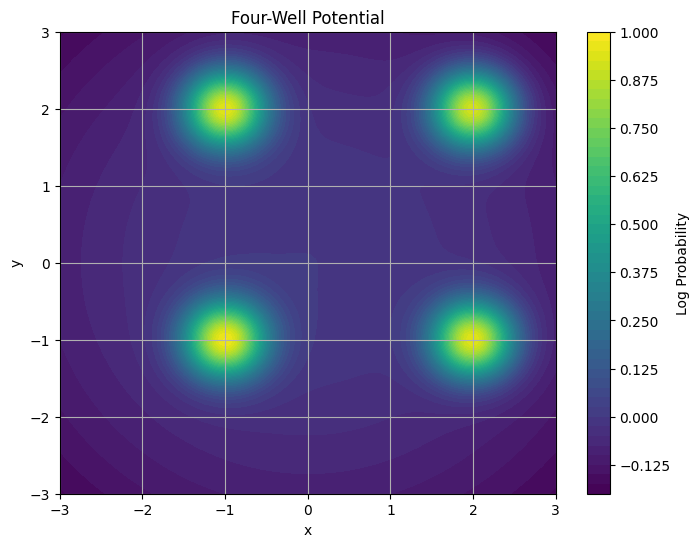

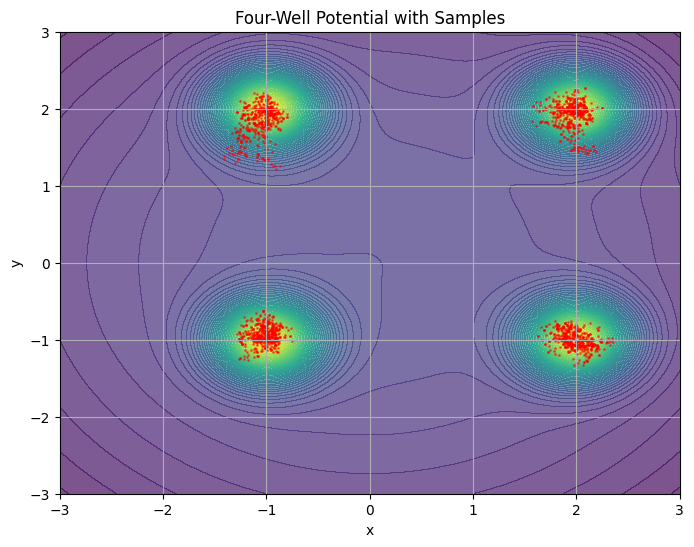

In [17]:
# Define a 2D energy function with four wells

class BaseEnergyFunction(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

    def energy(self, x):
        raise NotImplementedError

class FourWellEnergy(BaseEnergyFunction):
    def __init__(
        self,
        a=1.0,  # Controls the height of the barriers
        b=4.0,  # Controls the width of the wells
        shift=0.5,
        device="cpu",
        temperature=1.0,
        *args,
        **kwargs
    ):
        super().__init__(*args, **kwargs)
        self._dimensionality = 2
        self.device = device
        self.temperature = temperature
        self.a = a
        self.b = b
        
        # Define the locations of the four wells
        self.well_centers = torch.tensor([
            [-1.5, -1.5],  # Bottom left well (shifted by 1 on both axes)
            [-1.5, 1.5],   # Top left well (shifted by 1 on both axes)
            [1.5, -1.5],   # Bottom right well (shifted by 1 on both axes)
            [1.5, 1.5]     # Top right well (shifted by 1 on both axes)
        ], device=device)
        self.shift = shift
        self.well_centers += self.shift
        
    def _energy(self, x):
        """Compute the energy of the four-well potential."""
        # Ensure input is 2D
        if x.dim() == 1:
            x = x.unsqueeze(0)
            
        batch_size = x.shape[0]
        energies = torch.zeros(batch_size, device=self.device)
        
        # Calculate the contribution from each well
        for center in self.well_centers:
            # Calculate squared distance to each well center
            dist_sq = torch.sum((x - center)**2, dim=1)
            # Add negative Gaussian contribution (creates wells)
            energies -= self.a * torch.exp(-self.b * dist_sq)
            
        # Add a quadratic confinement to prevent samples from going too far
        confinement = 0.01 * torch.sum(x**2, dim=1)
        
        return energies + confinement
    
    def energy(self, x):
        return self._energy(x)
    
    def log_prob(self, x):
        return -self._energy(x) / self.temperature
    
    def log_prob_2D(self, x, y):
        """For 2D contour plotting"""
        points = torch.stack([x.flatten(), y.flatten()], dim=1)
        log_probs = self.log_prob(points)
        return log_probs.reshape(x.shape)

# Create the four-well energy function
four_well = FourWellEnergy(device=target.device)

# Visualize the four-well potential
x = torch.linspace(-3, 3, 100, device=four_well.device)
y = torch.linspace(-3, 3, 100, device=four_well.device)
X, Y = torch.meshgrid(x, y)
Z = four_well.log_prob_2D(X, Y)

plt.figure(figsize=(8, 6))
plt.contourf(X.cpu(), Y.cpu(), Z.cpu(), 50, cmap='viridis')
plt.colorbar(label='Log Probability')
plt.title('Four-Well Potential')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

# Generate samples from the four-well potential
# For simplicity, we'll use a basic MCMC approach
def sample_four_well(n_samples=1000, n_burnin=5000, step_size=0.05):
    samples = torch.zeros((n_samples, 2), device=four_well.device)
    
    # Start from a position near one of the wells
    # Either randomly choose one well center or start chains from all wells
    well_idx = torch.randint(0, len(four_well.well_centers), (1,)).item()
    # Add small noise to not start exactly at the center
    current = four_well.well_centers[well_idx] + 0.1 * torch.randn(2, device=four_well.device)
    current_log_prob = four_well.log_prob(current)
    
    # Burn-in phase
    for _ in range(n_burnin):
        proposal = current + step_size * torch.randn(2, device=four_well.device)
        proposal_log_prob = four_well.log_prob(proposal)
        
        # Metropolis acceptance with correct criterion
        acceptance_ratio = torch.min(
            torch.tensor(1.0, device=four_well.device),
            torch.exp(proposal_log_prob - current_log_prob)
        )
        
        if torch.rand(1, device=four_well.device) < acceptance_ratio:
            current = proposal
            current_log_prob = proposal_log_prob
    
    # Sampling phase
    for i in range(n_samples):
        proposal = current + step_size * torch.randn(2, device=four_well.device)
        proposal_log_prob = four_well.log_prob(proposal)
        
        # Metropolis acceptance
        acceptance_ratio = torch.min(
            torch.tensor(1.0, device=four_well.device),
            torch.exp(proposal_log_prob - current_log_prob)
        )
        
        if torch.rand(1, device=four_well.device) < acceptance_ratio:
            current = proposal
            current_log_prob = proposal_log_prob
        
        samples[i] = current
    
    return samples

# For better exploration of all wells, you could also run multiple chains and combine them:
def sample_four_well_all_wells(n_samples=2000, samples_per_well=500, n_burnin=1000, step_size=0.05):
    """Run multiple chains starting from each well center and combine the results"""
    samples_per_well = n_samples // len(four_well.well_centers)
    all_samples = []
    
    for well_idx in range(len(four_well.well_centers)):
        # Start near this well
        current = four_well.well_centers[well_idx] + 0.1 * torch.randn(2, device=four_well.device)
        current_log_prob = four_well.log_prob(current)
        
        # Initialize samples for this well
        samples = torch.zeros((samples_per_well, 2), device=four_well.device)
        
        # Burn-in phase
        for _ in range(n_burnin):
            proposal = current + step_size * torch.randn(2, device=four_well.device)
            proposal_log_prob = four_well.log_prob(proposal)
            
            acceptance_ratio = torch.min(
                torch.tensor(1.0, device=four_well.device),
                torch.exp(proposal_log_prob - current_log_prob)
            )
            
            if torch.rand(1, device=four_well.device) < acceptance_ratio:
                current = proposal
                current_log_prob = proposal_log_prob
        
        # Sampling phase
        for i in range(samples_per_well):
            proposal = current + step_size * torch.randn(2, device=four_well.device)
            proposal_log_prob = four_well.log_prob(proposal)
            
            acceptance_ratio = torch.min(
                torch.tensor(1.0, device=four_well.device),
                torch.exp(proposal_log_prob - current_log_prob)
            )
            
            if torch.rand(1, device=four_well.device) < acceptance_ratio:
                current = proposal
                current_log_prob = proposal_log_prob
            
            samples[i] = current
        
        all_samples.append(samples)
    
    # Combine samples from all wells
    return torch.cat(all_samples, dim=0)

# Try the multi-chain approach for better coverage
four_well = FourWellEnergy(a=2.0, b=4.0, shift=0.5, device=target.device, temperature=0.2)
four_well_samples = sample_four_well_all_wells(n_samples=2000, n_burnin=1000, step_size=0.05)

plt.figure(figsize=(8, 6))
plt.contourf(X.cpu(), Y.cpu(), Z.cpu(), 50, cmap='viridis', alpha=0.7)
plt.scatter(four_well_samples[:, 0].cpu(), four_well_samples[:, 1].cpu(), 
           s=1, color='red', alpha=0.5)
plt.title('Four-Well Potential with Samples')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()
